In [129]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os, glob
import numpy as np
import os
images = os.listdir("test_images/")
%matplotlib inline

print (images)

['solidYellowCurve2.jpg', 'solidWhiteCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg']


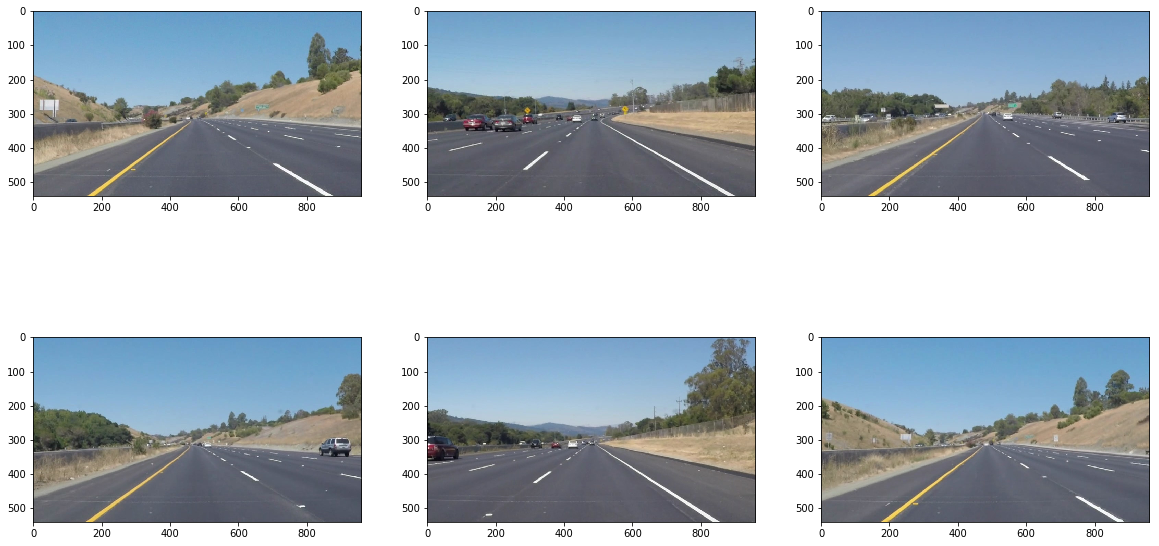

In [130]:
#display all images in the test image folder
plt.figure(figsize=[20, 11])
#The optional argument allows us to tell enumerate from where to start the index.
for i, image in enumerate(images, 1):
    img = mpimg.imread('test_images/' + image)
    plt.subplot(2, 3, i)
    plt.imshow(img)

(540, 960, 3)


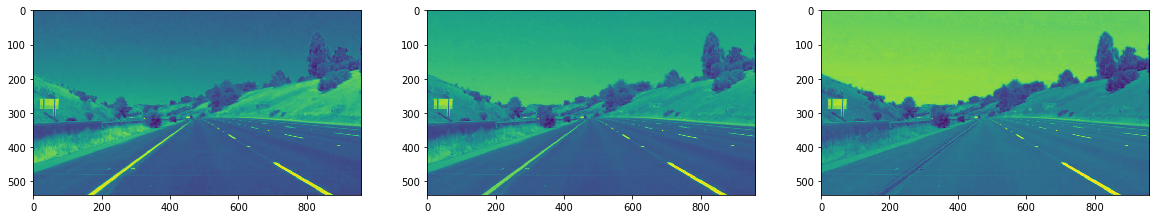

In [131]:
# display B, G, R images
img = mpimg.imread('test_images/solidYellowCurve2.jpg')
print (img.shape)
plt.figure(figsize=[20, 11])
B_channel = img[:,:,0]
G_channel = img[:,:,1]
R_channel = img[:,:,2]
img_channels = [B_channel, G_channel, R_channel]
for i, img in enumerate(img_channels, 1):    
    plt.subplot(1, 3, i)
    plt.imshow(img)

In [132]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, 
                            np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0],img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

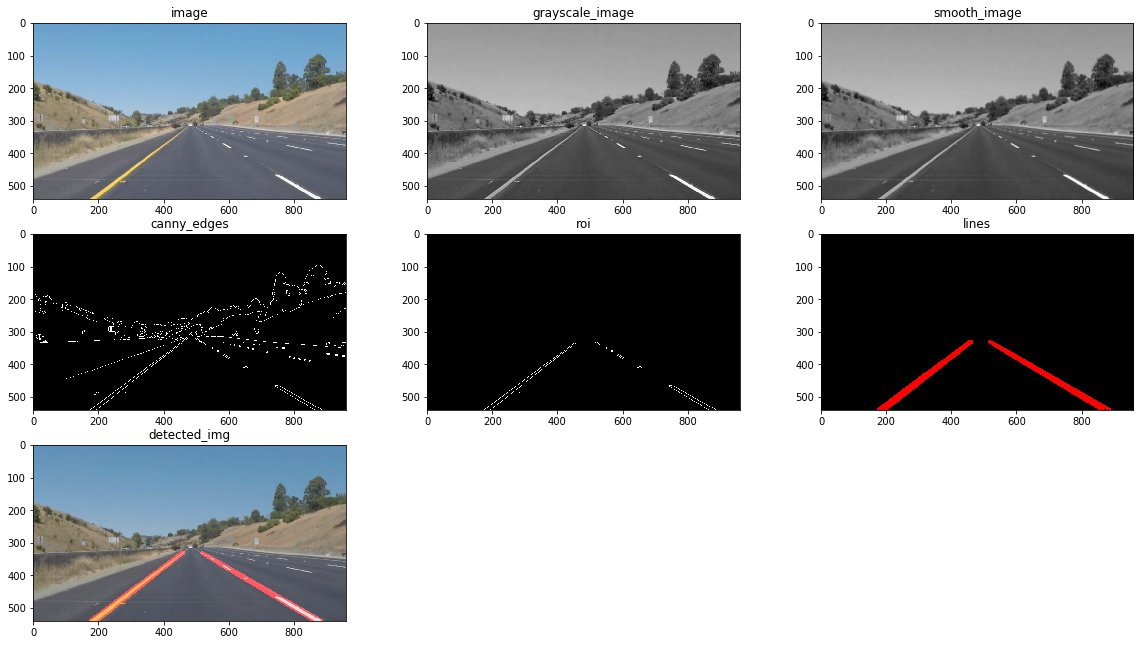

In [176]:
KERNEL_SIZE = 5
LOW_THRESHOLD = 50 # threshold for canny edge detector
HIGH_THRESHOLD = 150 # threshold for canny edge detector

grayscale_image = grayscale(img)
smooth_image = gaussian_blur(grayscale_image, KERNEL_SIZE)
canny_edges = canny(smooth_image, LOW_THRESHOLD, HIGH_THRESHOLD)

height = canny_edges.shape[0]
width = canny_edges.shape[1]
interest = np.array([[(135, height),(900, height),(535, 330),(435, 330)]])
roi = region_of_interest(canny_edges, [interest])
lines_image = hough_lines(roi, 1, np.pi/180, 32, 1, 200)

detected_img = weighted_img(lines_image, img, α=0.9, β=1., λ=0.)

imgs = [img, grayscale_image, smooth_image, canny_edges, roi, lines_image, detected_img]
img_names = ['image', 'grayscale_image', 'smooth_image', 'canny_edges', 'roi', 'lines', 'detected_img']

plt.figure(figsize=[20, 11])
#The optional argument allows us to tell enumerate from where to start the index.
for i, img in enumerate(imgs, 1):
    plt.subplot(3, 3, i)
    plt.title('{}'.format(img_names[i-1]))
    plt.imshow(img, cmap='gray')


In [177]:
#hough lines
rho = 1
theta = np.pi/180
threshold = 30
min_line_len = 20 
max_line_gap = 200
def line_detect(img):
    grayscale_image = grayscale(img)
    smooth_image = gaussian_blur(grayscale_image, KERNEL_SIZE)
    canny_edges = canny(smooth_image, LOW_THRESHOLD, HIGH_THRESHOLD)
    roi = region_of_interest(canny_edges, [interest])
    #lines_image = hough_lines(roi, 1, np.pi/180, 32, 1, 200)
    lines_image = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)
    detected_img = weighted_img(lines_image, img, α=0.9, β=1., λ=0.)
    return detected_img

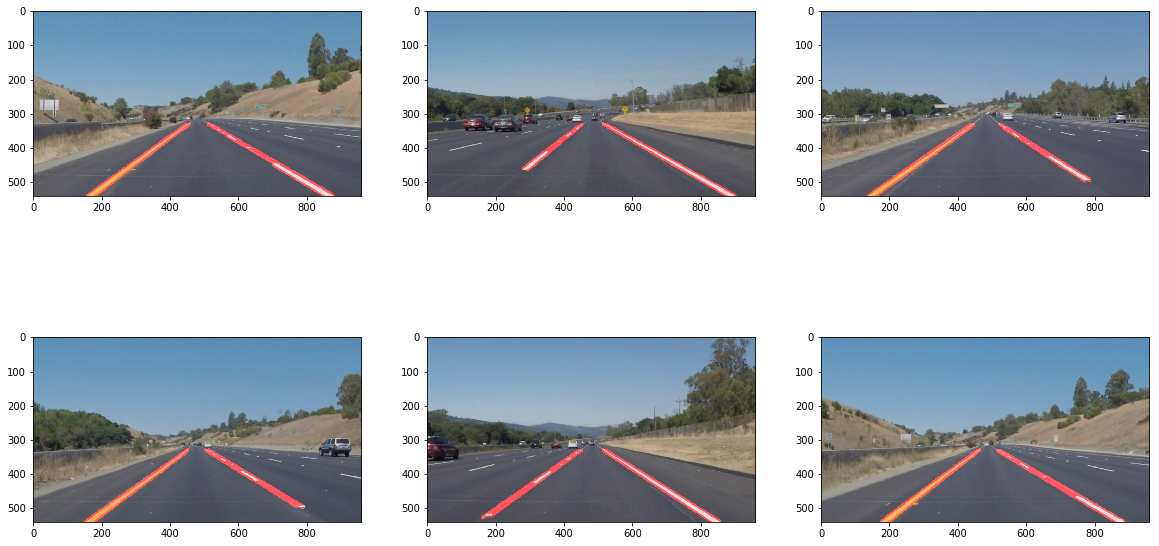

In [178]:
# apply line_detect function on all test images
plt.figure(figsize=[20, 11])
#The optional argument allows us to tell enumerate from where to start the index.
for i, image in enumerate(images, 1):
    img = mpimg.imread('test_images/' + image)
    detected_image = line_detect(img)
    plt.subplot(2, 3, i)
    plt.imshow(detected_image)

In [144]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [166]:
# apply line_detect function to test videos
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(line_detect)
#%time white_clip.write_videofile(white_output, audio=False)
%time white_clip.write_gif('white_output.gif', fps=5)


[MoviePy] Building file white_output.gif with imageio


100%|██████████| 45/45 [00:08<00:00,  6.11it/s]

CPU times: user 7.55 s, sys: 184 ms, total: 7.73 s
Wall time: 8.42 s


In [130]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [126]:
yellow_output = 'yellow.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(line_detect)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:21<00:00, 31.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.7 s, sys: 1.62 s, total: 12.3 s
Wall time: 23.2 s


In [131]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))